# Imports 

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: False


# Load Dataset
WELFake from HuggingFace

In [4]:
from datasets import load_dataset

dataset = load_dataset("lelexuanzz/WELFake_stylo_feats")
print(dataset)

Generating train split: 100%|██████████| 70793/70793 [00:00<00:00, 91544.11 examples/s] 


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'has_quotes', 'has_url', 'percent_uppercase', 'frequency_punctuation', 'percent_whitespace', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'avg_sentence_length'],
        num_rows: 70793
    })
})


## Split dataset

In [5]:
#convert dataset to pandas for easier implementation with sklearn

df = dataset["train"].to_pandas()
print(df)

                                                    text  label  has_quotes  \
0      No comment is expected from Barack Obama Membe...      1           0   
1       Now, most of the demonstrators gathered last ...      1           0   
2      A dozen politically active pastors came here f...      0           0   
3      The RS-28 Sarmat missile, dubbed Satan 2, will...      1           0   
4      All we can say on this one is it s about time ...      1           0   
...                                                  ...    ...         ...   
70788  WASHINGTON (Reuters) - Hackers believed to be ...      0           0   
70789  You know, because in fantasyland Republicans n...      1           0   
70790  Migrants Refuse To Leave Train At Refugee Camp...      0           1   
70791  MEXICO CITY (Reuters) - Donald Trump’s combati...      0           0   
70792  Goldman Sachs Endorses Hillary Clinton For Pre...      1           0   

       has_url  percent_uppercase  frequency_punctu

In [10]:
from sklearn.model_selection import train_test_split

seed = 45

y = df["label"]
x = df.drop(labels=["label","text"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

print(x_train, y_train)

       has_quotes  has_url  percent_uppercase  frequency_punctuation  \
33090           0        0           4.365983                     42   
13814           0        1           2.970607                     70   
47609           0        0           3.880804                     29   
30722           0        0           3.251016                     67   
1945            0        1           2.789491                     77   
...           ...      ...                ...                    ...   
12895           0        1           3.202995                     61   
60960           0        1           2.864939                     32   
6012            0        1          17.731959                     11   
63107           0        0           3.806452                     30   
6558            0        0           5.263158                      4   

       percent_whitespace  frequency_words_length_15  \
33090           16.362946                          0   
13814           16.8230

### Training

no further preprocessing

In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [12]:
# scale features
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [13]:
# instantiate with default params first
gnb = GaussianNB()
gnb.fit(x_train_scaled, y_train)

GaussianNB()

In [14]:
# predict
y_pred = gnb.predict(x_test_scaled)

In [15]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.5755349954092803


In [16]:
# classification report (precision, recall, f1)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.90      0.68      7006
           1       0.72      0.26      0.38      7153

    accuracy                           0.58     14159
   macro avg       0.63      0.58      0.53     14159
weighted avg       0.63      0.58      0.53     14159



## Visualize feature importance
Feature Importance Formula for GaussianNB:
Feature Importance ≈ |mean₀ − mean₁| / √(var₀ + var₁)

Where:
- mean₀: Mean of feature values for class 0
- mean₁: Mean of feature values for class 1
- var₀: Variance of feature values for class 0
- var₁: Variance of feature values for class 1

This formula captures the difference between class distributions and scales it by how spread out the data is in each class.

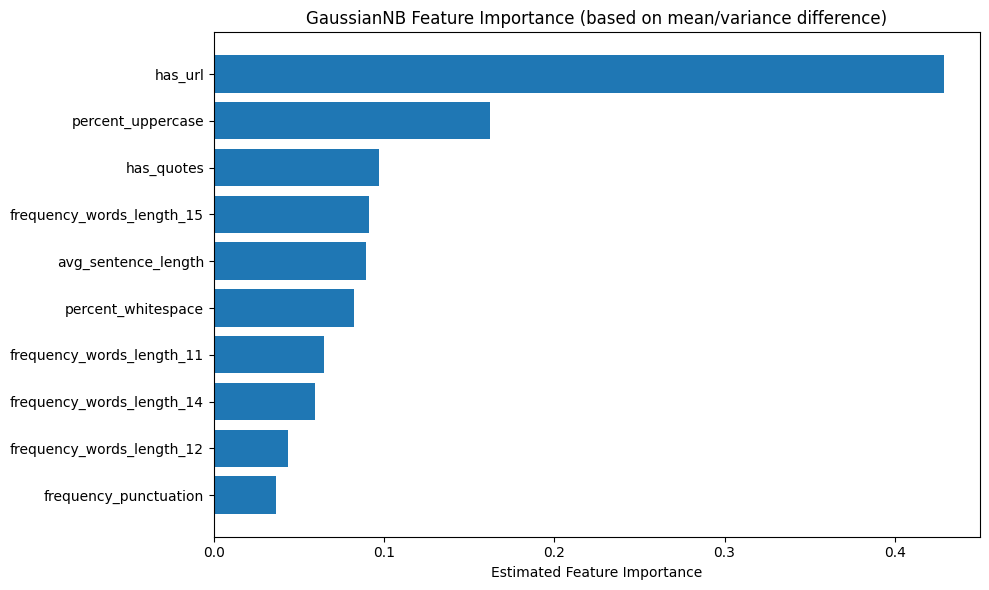

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Feature Importance ≈ |mean₀ − mean₁| / √(var₀ + var₁)
mean_diff = np.abs(gnb.theta_[0] - gnb.theta_[1])  # absolute difference in means
var_sum = np.sqrt(gnb.var_[0] + gnb.var_[1])       # combined std dev
importance_scores = mean_diff / var_sum            # signal-to-noise ratio

# Sort scores and plot
features = x_train.columns
sorted_idx = np.argsort(importance_scores)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], importance_scores[sorted_idx])
plt.xlabel("Estimated Feature Importance")
plt.title("GaussianNB Feature Importance (based on mean/variance difference)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Hyperparameter Tuning with Grid Search

In [18]:
from sklearn.model_selection import GridSearchCV

# define parameter grid for GridSearchCV for GaussianNB
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

grid_search = GridSearchCV(gnb, param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# fit the grid search to the training data
grid_search.fit(x_train_scaled, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]},
             scoring='accuracy', verbose=1)

In [28]:
import json

# Best model after grid search
gaussian_model = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Make predictions on the test set using the best model
y_pred = gaussian_model.predict(x_test_scaled)
print("Accuracy after GridSearchCV:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best Hyperparameters: {'var_smoothing': 1e-09}
Accuracy after GridSearchCV: 0.5755349954092803

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.90      0.68      7006
           1       0.72      0.26      0.38      7153

    accuracy                           0.58     14159
   macro avg       0.63      0.58      0.53     14159
weighted avg       0.63      0.58      0.53     14159



## K-fold Cross Validation

In [29]:
from sklearn.model_selection import cross_val_score

# perform K-fold cross-validation (e.g., 5 folds)
cv_scores = cross_val_score(gaussian_model, x_train_scaled, y_train, cv=5, scoring='accuracy')

# print cross-validation results
print(f"K-fold Cross-validation scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean()}")

K-fold Cross-validation scores: [0.57128984 0.57349695 0.56422707 0.56846473 0.56445347]
Mean accuracy: 0.5683864121739188


## Evaluate model with best parameter

In [30]:
import json

# Make predictions on the test set using the best model
y_pred_best = gaussian_model.predict(x_test_scaled)

# Evaluate accuracy
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Test accuracy with best parameters: {:.4f}".format(accuracy_best))
report = classification_report(y_test, y_pred_best, target_names=['Real', 'Fake'], output_dict=True)
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))
metrics = {"accuracy": accuracy_best, "classification_report": report}
with open('./results/nb_gaussian_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

Test accuracy with best parameters: 0.5755

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.90      0.68      7006
           1       0.72      0.26      0.38      7153

    accuracy                           0.58     14159
   macro avg       0.63      0.58      0.53     14159
weighted avg       0.63      0.58      0.53     14159



## Save best model in joblib

In [33]:
import joblib

# Save the best model to a file
joblib.dump(gaussian_model, './models/gaussian_model.pkl')
print("Model saved as gaussian_model.pkl")

Model saved as gaussian_model.pkl


In [32]:
# Load the best model from file
gaussian_model = joblib.load('best_gaussian_model.joblib')

# Use the model to make predictions again
y_pred = gaussian_model.predict(x_test_scaled)